* Goal: demo user driver develop process (focus on read-only driver)
* Outcome: a workable user-developed driver (request data from currency public RestAPI.) P.S.: To verify, Publish data in Sqlite-historian, display the result.
* Pre-requisite: a running volttron instance (ref: single-machien setup)
* Plan: ...

## Final Results: view as volttron.log

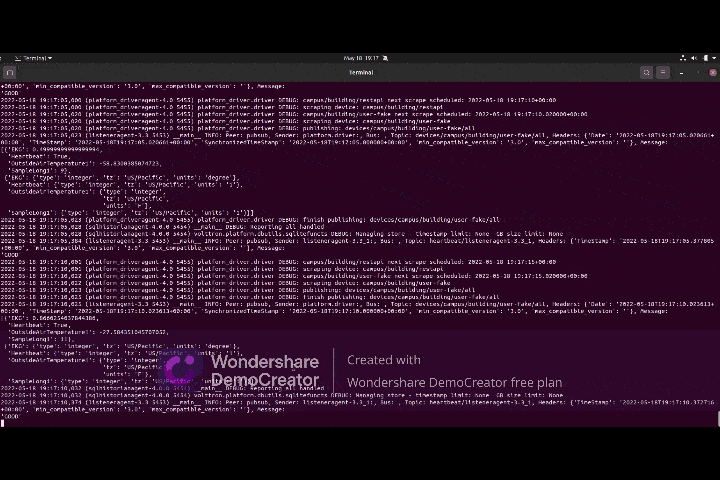

## Final Results: view in the sqlite-historian

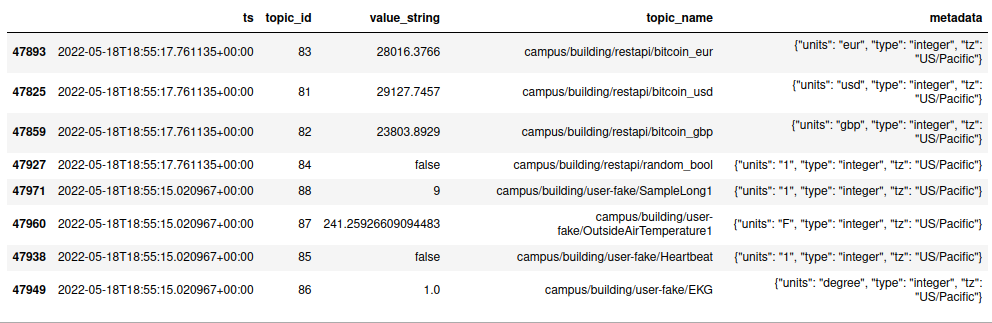

### Steps

1. preparation: explore the data, determine the goal, draft the input-output data schema. Go over the vctl command we are going to use. Go over the files we need to prepare.
2. configure the user-driver-config.csv and user-driver-config.config files.
    1. TODO/DOING: methods to validate config files.
    2. Solid example explain what each field really does, e.g., driver_config session
3. implement the `get_register_value` method for UserDevDriver class
    1. unit testable
4. assign/specify register_types_list 
    1. one liner
    2. need to match the point configuration
5. Manually testing 
    1. testing in single-machine setup
    2. observe volttron.log, (optional: inspect historian—I like to do things end-to-end)
    3. point-out the critical place for checking (e.g., where I put print)
6. Polishing as needed
    1. centralized configuration vs. hardcode(discussion: environment variable alternatives)
    2. refactor
    3. write docstring
    4. documentation, tutorial

### File for code review purpose (TODO: delete this)

* platform_driver/interfaces/user_driver_demo.py: https://github.com/kefeimo/volttron/blob/new-feature/driver-template/services/core/PlatformDriverAgent/platform_driver/interfaces/user_driver_demo.py

* platform_driver/interfaces/driver_template.py: https://github.com/kefeimo/volttron/blob/new-feature/driver-template/services/core/PlatformDriverAgent/platform_driver/interfaces/driver_template.py

* notebooks/user-dev-driver-template.config: https://github.com/kefeimo/volttron/blob/new-feature/driver-template/notebooks/user-dev-driver-template.config

* notebooks/user-dev-driver-template.csv: https://github.com/kefeimo/volttron/blob/new-feature/driver-template/notebooks/user-dev-driver-template.csv

* this notebook: https://github.com/kefeimo/volttron/blob/new-feature/driver-template/notebooks/user-driver-develop-demo.ipynb

bonus
* user_driver_demo_fake.py: https://github.com/kefeimo/volttron/blob/new-feature/driver-template/services/core/PlatformDriverAgent/platform_driver/interfaces/user_driver_demo_fake.py

comment about csv -config
keep the original one. Make documentation to explain what each field actually means. e.g., volltron point vs. point name
key point: configure 
we need required field
* ...
ref: https://volttron.readthedocs.io/en/develop/driver-framework/platform-driver/platform-driver.html#registry-configuration-file



comment on "heart_beat_point": "random_bool",
some need it some do not.

ref: https://volttron.readthedocs.io/en/develop/driver-framework/platform-driver/platform-driver.html#driver-configuration-file



Find/confirm with readthedoc what should be madatory what is optional. 
breadth first


try to under this first

"publish_breadth_first_all": false,
"publish_depth_first": false,
"publish_breadth_first": false,
    
    
the current configure is confusing.

missing ""publish_breadth_first_all": (by default "publish_breadth_first_all": true:

ref: https://volttron.readthedocs.io/en/develop/driver-framework/platform-driver/platform-driver.html#id2

In [1]:
import sqlite3
import pandas as pd
from pandas.core.frame import DataFrame
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

from matplotlib import pyplot as plt
from time import sleep

import matplotlib


# import gnuplotlib as gp
import numpy as np

import sys

import requests

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
# Step x: configure the user-dev-driver-template.csv

In [4]:
import pandas as pd
config_csv = pd.read_csv("user-dev-driver-template.csv")
config_csv.head()

PointName DataType Units  ReadOnly  DefaultValue  \
0  bitcoin_usd    float   usd      True           NaN   
1  bitcoin_gbp    float   gbp      True           NaN   
2  bitcoin_eur    float   eur      True           NaN   
3  random_bool     bool     1      True           NaN   

                   Description  PointNameDetail         DataTypeDetail  \
0  Bit coin value in US dollar              NaN  float type in python.   
1  Bit coin value in US dollar              NaN  float type in python.   
2  Bit coin value in US dollar              NaN  float type in python.   
3            Random bool value              NaN                    NaN   

   UnitsDetail  ReadOnlyDetail  DefaultValueDetail  ExtraNotes  
0          NaN             NaN                 NaN         NaN  
1          NaN             NaN                 NaN         NaN  
2          NaN             NaN                 NaN         NaN  
3          NaN             NaN                 NaN         NaN

### Fill out the csv template


In [5]:
config_csv.to_dict()

{'PointName': {0: 'bitcoin_usd',
  1: 'bitcoin_gbp',
  2: 'bitcoin_eur',
  3: 'random_bool'},
 'DataType': {0: 'float', 1: 'float', 2: 'float', 3: 'bool'},
 'Units': {0: 'usd', 1: 'gbp', 2: 'eur', 3: '1'},
 'ReadOnly': {0: True, 1: True, 2: True, 3: True},
 'DefaultValue': {0: nan, 1: nan, 2: nan, 3: nan},
 'Description': {0: 'Bit coin value in US dollar',
  1: 'Bit coin value in US dollar',
  2: 'Bit coin value in US dollar',
  3: 'Random bool value'},
 'PointNameDetail': {0: nan, 1: nan, 2: nan, 3: nan},
 'DataTypeDetail': {0: 'float type in python.',
  1: 'float type in python.',
  2: 'float type in python.',
  3: nan},
 'UnitsDetail': {0: nan, 1: nan, 2: nan, 3: nan},
 'ReadOnlyDetail': {0: nan, 1: nan, 2: nan, 3: nan},
 'DefaultValueDetail': {0: nan, 1: nan, 2: nan, 3: nan},
 'ExtraNotes': {0: nan, 1: nan, 2: nan, 3: nan}}

In [6]:
config_csv.to_json()

'{"PointName":{"0":"bitcoin_usd","1":"bitcoin_gbp","2":"bitcoin_eur","3":"random_bool"},"DataType":{"0":"float","1":"float","2":"float","3":"bool"},"Units":{"0":"usd","1":"gbp","2":"eur","3":"1"},"ReadOnly":{"0":true,"1":true,"2":true,"3":true},"DefaultValue":{"0":null,"1":null,"2":null,"3":null},"Description":{"0":"Bit coin value in US dollar","1":"Bit coin value in US dollar","2":"Bit coin value in US dollar","3":"Random bool value"},"PointNameDetail":{"0":null,"1":null,"2":null,"3":null},"DataTypeDetail":{"0":"float type in python.","1":"float type in python.","2":"float type in python.","3":null},"UnitsDetail":{"0":null,"1":null,"2":null,"3":null},"ReadOnlyDetail":{"0":null,"1":null,"2":null,"3":null},"DefaultValueDetail":{"0":null,"1":null,"2":null,"3":null},"ExtraNotes":{"0":null,"1":null,"2":null,"3":null}}'

In [7]:
# Scafolding provided

In [8]:
import sys
sys.path

['/home/kefei/sandbox/volttron/notebooks',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/kefei/volttron/env/lib/python3.8/site-packages',
 '/home/kefei/volttron']

In [9]:
# add the path if needed
# e.g., sys.path.append("/home/kefei/sandbox/volttron/services/core/PlatformDriverAgent")
sys.path.append("/home/kefei/sandbox/volttron/services/core/PlatformDriverAgent")

# to remove
# sys.path.remove("/some-path")


In [10]:
from platform_driver.interfaces.driver_template import TemplateInterface, TemplateRegister
from platform_driver.interfaces.driver_template import ImplementedRegister, RegisterValue
from typing import List, Optional

# TODO-developer: Your code here
# Add dependency as needed, and update in requirements



# TODO-developer: Your code here
# Change the classname "UserDevelopRegister" as needed
class UserDevelopRegister(TemplateRegister):
    # boilerplate code. Don't touch me.
    def __init__(self, 
                 driver_config: dict, 
                 point_name: str, 
                 data_type: RegisterValue, 
                 units: str, read_only: bool,
                 default_value: Optional[RegisterValue] = None, 
                 description: str = ""): # re-define for redability
        super().__init__(driver_config, point_name, data_type, units, default_value, description)

    def get_register_value(self) -> RegisterValue:
        # TODO-developer: Your code here
        # Implemet get-register-value logic here
        # Note: Keep the method name as it is including the signatures.
        # Use a helper method if needed.
        
        # EXAMPLE:
        # def get_register_value(self):
        #    return _get_register_value_helper(url=self.driver_config.get("url"))
        # def _get_register_value_helper(self, url: str):
        #    ...
        pass



        
        
# TODO-developer: Your code here
# fill in regeister_types with register types accordingly
# EXAMPLE:
# register_types = [UserDevelopRegister, UserDevelopRegister]
register_types: List[ImplementedRegister]
register_types = []


# boilerplate code. Don't touch me.
class Interface(TemplateInterface):
    def pass_register_types(self):
        return register_types




In [11]:
from platform_driver.interfaces.driver_template import TemplateInterface, TemplateRegister
from platform_driver.interfaces.driver_template import ImplementedRegister, RegisterValue
from typing import List, Optional

# TODO-developer: Your code here
# Add dependency as needed, and update in requirements
import json



# TODO-developer: Your code here
# Change the classname "UserDevelopRegister" as needed
class UserDevelopRegister(TemplateRegister):
    # boilerplate code. Don't touch me.
    def __init__(self, 
                 driver_config: dict, 
                 point_name: str, 
                 data_type: RegisterValue, 
                 units: str, read_only: bool,
                 default_value: Optional[RegisterValue] = None, 
                 description: str = ""): # re-define for redability
        super().__init__(driver_config, point_name, data_type, units, default_value, description)

    def get_register_value(self) -> RegisterValue:
        # TODO-developer: Your code here
        # Implemet get-register-value logic here
        # Note: Keep the method name as it is including the signatures.
        # Use a helper method if needed.
        
        # EXAMPLE:
        # def get_register_value(self) -> RegisterValue:
        #    return _get_register_value_helper(url=self.driver_config.get("url"))
        # def _get_register_value_helper(self, url: str):
        #    ...
        
#         print("silly implementation")
        return self._get_json_fromrestapi(url="https://api.coindesk.com/v1/bpi/currentprice.json")
    
    def _get_json_fromrestapi(self, url: str) -> dict:
        response: json = requests.get(url)
        response_str: str = response.json()
        return response_str



        
        
# TODO-developer: Your code here
# fill in regeister_types with register types accordingly
# EXAMPLE:
# register_types = [UserDevelopRegister, UserDevelopRegister]
register_types: List[ImplementedRegister]
register_types = []


# boilerplate code. Don't touch me.
class Interface(TemplateInterface):
    def pass_register_types(self):
        return register_types




In [12]:
udr = UserDevelopRegister(driver_config={},
    point_name="point_name_demo",
    data_type=str,
    units="1",
    read_only=True,
    default_value=None,
    description='',)

In [13]:
# Note: your result would be different
udr.get_register_value()

{'time': {'updated': 'May 18, 2022 20:42:00 UTC',
  'updatedISO': '2022-05-18T20:42:00+00:00',
  'updateduk': 'May 18, 2022 at 21:42 BST'},
 'disclaimer': 'This data was produced from the CoinDesk Bitcoin Price Index (USD). Non-USD currency data converted using hourly conversion rate from openexchangerates.org',
 'chartName': 'Bitcoin',
 'bpi': {'USD': {'code': 'USD',
   'symbol': '&#36;',
   'rate': '29,010.0223',
   'description': 'United States Dollar',
   'rate_float': 29010.0223},
  'GBP': {'code': 'GBP',
   'symbol': '&pound;',
   'rate': '23,707.6865',
   'description': 'British Pound Sterling',
   'rate_float': 23707.6865},
  'EUR': {'code': 'EUR',
   'symbol': '&euro;',
   'rate': '27,903.1449',
   'description': 'Euro',
   'rate_float': 27903.1449}}}

### Tips: use a json reader to view the result
ref:
* https://jsoneditoronline.org/#left=local.pocaba
* https://codebeautify.org/jsonviewer



In [14]:
sample_response: dict = {'time': {'updated': 'May 17, 2022 22:33:00 UTC',
  'updatedISO': '2022-05-17T22:33:00+00:00',
  'updateduk': 'May 17, 2022 at 23:33 BST'},
 'disclaimer': 'This data was produced from the CoinDesk Bitcoin Price Index (USD). Non-USD currency data converted using hourly conversion rate from openexchangerates.org',
 'chartName': 'Bitcoin',
 'bpi': {'USD': {'code': 'USD',
   'symbol': '&#36;',
   'rate': '30,310.2983',
   'description': 'United States Dollar',
   'rate_float': 30310.2983},
  'GBP': {'code': 'GBP',
   'symbol': '&pound;',
   'rate': '24,770.3032',
   'description': 'British Pound Sterling',
   'rate_float': 24770.3032},
  'EUR': {'code': 'EUR',
   'symbol': '&euro;',
   'rate': '29,153.8089',
   'description': 'Euro',
   'rate_float': 29153.8089}}}
sample_response

{'time': {'updated': 'May 17, 2022 22:33:00 UTC',
  'updatedISO': '2022-05-17T22:33:00+00:00',
  'updateduk': 'May 17, 2022 at 23:33 BST'},
 'disclaimer': 'This data was produced from the CoinDesk Bitcoin Price Index (USD). Non-USD currency data converted using hourly conversion rate from openexchangerates.org',
 'chartName': 'Bitcoin',
 'bpi': {'USD': {'code': 'USD',
   'symbol': '&#36;',
   'rate': '30,310.2983',
   'description': 'United States Dollar',
   'rate_float': 30310.2983},
  'GBP': {'code': 'GBP',
   'symbol': '&pound;',
   'rate': '24,770.3032',
   'description': 'British Pound Sterling',
   'rate_float': 24770.3032},
  'EUR': {'code': 'EUR',
   'symbol': '&euro;',
   'rate': '29,153.8089',
   'description': 'Euro',
   'rate_float': 29153.8089}}}

In [15]:
time_updated: str = sample_response.get("time").get("updated")
time_updated

'May 17, 2022 22:33:00 UTC'

In [16]:
bitcoin_USD: str = sample_response.get("bpi").get("USD").get("rate")
bitcoin_USD

'30,310.2983'

In [17]:
bitcoin_GBP: str = sample_response.get("bpi").get("GBP").get("rate")
bitcoin_GBP

'24,770.3032'

In [18]:
bitcoin_EUR: str = sample_response.get("bpi").get("EUR").get("rate")
bitcoin_EUR

'29,153.8089'

In [19]:
from platform_driver.interfaces.driver_template import TemplateInterface, TemplateRegister
from platform_driver.interfaces.driver_template import ImplementedRegister, RegisterValue
from typing import List, Optional

# TODO-developer: Your code here
# Add dependency as needed, and update in requirements
import json



# TODO-developer: Your code here
# Change the classname "UserDevelopRegister" as needed
class UserDevelopRegisterTimeUpdated(TemplateRegister):
    # boilerplate code. Don't touch me.
    def __init__(self, 
                 driver_config: dict, 
                 point_name: str, 
                 data_type: RegisterValue, 
                 units: str, read_only: bool,
                 default_value: Optional[RegisterValue] = None, 
                 description: str = ""): # re-define for redability
        super().__init__(driver_config, point_name, data_type, units, default_value, description)

    def get_register_value(self) -> RegisterValue:
        # TODO-developer: Your code here
        # Implemet get-register-value logic here
        # Note: Keep the method name as it is including the signatures.
        # Use a helper method if needed.
        
        # EXAMPLE:
        # def get_register_value(self) -> RegisterValue:
        #    return _get_register_value_helper(url=self.driver_config.get("url"))
        # def _get_register_value_helper(self, url: str):
        #    ...
        
#         print("silly implementation")
        return self._get_json_fromrestapi(url="https://api.coindesk.com/v1/bpi/currentprice.json")
    
    def _get_json_fromrestapi(self, url: str) -> dict:
        response: json = requests.get(url)
        response_str: str = response.json()
        time_updated: str = response_str.get("time").get("updated")

        return time_updated


class UserDevelopRegisterBitcoinUSD(TemplateRegister):
    # boilerplate code. Don't touch me.
    def __init__(self, 
                 driver_config: dict, 
                 point_name: str, 
                 data_type: RegisterValue, 
                 units: str, read_only: bool,
                 default_value: Optional[RegisterValue] = None, 
                 description: str = ""): # re-define for redability
        super().__init__(driver_config, point_name, data_type, units, default_value, description)

    def get_register_value(self) -> RegisterValue:
        return self._get_json_fromrestapi(url="https://api.coindesk.com/v1/bpi/currentprice.json")
    
    def _get_json_fromrestapi(self, url: str) -> dict:
        response: json = requests.get(url)
        response_str: str = response.json()
        bitcoin_usd: str = response_str.get("bpi").get("USD").get("rate")

        return bitcoin_usd
    
class UserDevelopRegisterBitcoinGBP(TemplateRegister):
    # boilerplate code. Don't touch me.
    def __init__(self, 
                 driver_config: dict, 
                 point_name: str, 
                 data_type: RegisterValue, 
                 units: str, read_only: bool,
                 default_value: Optional[RegisterValue] = None, 
                 description: str = ""): # re-define for redability
        super().__init__(driver_config, point_name, data_type, units, default_value, description)

    def get_register_value(self) -> RegisterValue:
        return self._get_json_fromrestapi(url="https://api.coindesk.com/v1/bpi/currentprice.json")
    
    def _get_json_fromrestapi(self, url: str) -> dict:
        response: json = requests.get(url)
        response_str: str = response.json()
        bitcoin_gbp: str = response_str.get("bpi").get("GBP").get("rate")

        return bitcoin_gbp
    

class UserDevelopRegisterBitcoinEUR(TemplateRegister):
    # boilerplate code. Don't touch me.
    def __init__(self, 
                 driver_config: dict, 
                 point_name: str, 
                 data_type: RegisterValue, 
                 units: str, read_only: bool,
                 default_value: Optional[RegisterValue] = None, 
                 description: str = ""): # re-define for redability
        super().__init__(driver_config, point_name, data_type, units, default_value, description)

    def get_register_value(self) -> RegisterValue:
        return self._get_json_fromrestapi(url="https://api.coindesk.com/v1/bpi/currentprice.json")
    
    def _get_json_fromrestapi(self, url: str) -> dict:
        response: json = requests.get(url)
        response_str: str = response.json()
        bitcoin_eur: str = response_str.get("bpi").get("EUR").get("rate")

        return bitcoin_eur

        
        
# TODO-developer: Your code here
# fill in regeister_types with register types accordingly
# EXAMPLE:
# register_types = [UserDevelopRegister, UserDevelopRegister]
register_types: List[ImplementedRegister]
register_types = []


# boilerplate code. Don't touch me.
class Interface(TemplateInterface):
    def pass_register_types(self):
        return register_types




In [20]:
udr_timeupdated = UserDevelopRegisterTimeUpdated(driver_config={},
    point_name="time_updated",
    data_type=str,
    units="1",
    read_only=True,
    default_value=None,
    description='',)
udr_timeupdated.get_register_value()

'May 18, 2022 20:42:00 UTC'

In [21]:
udr_USD = UserDevelopRegisterBitcoinUSD(driver_config={},
    point_name="bitcoin_usd",
    data_type=str,
    units="1",
    read_only=True,
    default_value=None,
    description='',)
udr_USD.get_register_value()

'29,010.0223'

In [22]:
udr_GBP = UserDevelopRegisterBitcoinGBP(driver_config={},
    point_name="bitcoin_gbp",
    data_type=str,
    units="1",
    read_only=True,
    default_value=None,
    description='',)
udr_GBP.get_register_value()

'23,707.6865'

In [23]:
udr_EUR = UserDevelopRegisterBitcoinEUR(driver_config={},
    point_name="bitcoin_eru",
    data_type=str,
    units="1",
    read_only=True,
    default_value=None,
    description='',)
udr_EUR.get_register_value()

'27,902.4115'

In [24]:
# That's a bit bulky, let's simplify that. (e.g., Generalize the method)
# The idea: let's use point_name to distinguish the method
# Note: using point name is a best practice/design-pattern to develop user register

In [25]:
from platform_driver.interfaces.driver_template import TemplateInterface, TemplateRegister
from platform_driver.interfaces.driver_template import ImplementedRegister, RegisterValue
from typing import List, Optional
import numpy as np

# TODO-developer: Your code here
# Add dependency as needed, and update in requirements
import json



# TODO-developer: Your code here
# Change the classname "UserDevelopRegister" as needed
class UserDevelopRegisterBitcoinRestAPI(TemplateRegister):
    # boilerplate code. Don't touch me.
    def __init__(self, 
                 driver_config: dict, 
                 point_name: str, 
                 data_type: RegisterValue, 
                 units: str, read_only: bool,
                 default_value: Optional[RegisterValue] = None, 
                 description: str = ""): # re-define for redability
        super().__init__(driver_config, point_name, data_type, units, default_value, description)

    def get_register_value(self) -> RegisterValue:
        # TODO-developer: Your code here
        # Implemet get-register-value logic here
        # Note: Keep the method name as it is including the signatures.
        # Use a helper method if needed.
        
        # EXAMPLE:
        # def get_register_value(self) -> RegisterValue:
        #    return _get_register_value_helper(url=self.driver_config.get("url"))
        # def _get_register_value_helper(self, url: str):
        #    ...
        
#         print("silly implementation")
        return self._get_json_fromrestapi(url="https://api.coindesk.com/v1/bpi/currentprice.json")
    
    def _get_json_fromrestapi(self, url: str) -> dict:
        response: json = requests.get(url)
        response_str: str = response.json()
            
        time_updated: str = response_str.get("time").get("updated")
        bitcoin_usd = response_str.get("bpi").get("USD").get("rate")
        bitcoin_usd = self._save_parse_to_float(bitcoin_usd)
        bitcoin_gbp = response_str.get("bpi").get("GBP").get("rate")
        bitcoin_gbp = self._save_parse_to_float(bitcoin_gbp)
        bitcoin_eur = response_str.get("bpi").get("EUR").get("rate")
        bitcoin_eur = self._save_parse_to_float(bitcoin_eur)
            
        return_point_value: RegisterValue
            
        if self.point_name=="time_updated":
            return_point_value = time_updated
        elif self.point_name=="bitcoin_usd":
            return_point_value = bitcoin_usd
        elif self.point_name=="bitcoin_gbp":
            return_point_value = bitcoin_gbp
        elif self.point_name=="bitcoin_eur":
            return_point_value = bitcoin_eur
        else:
            raise ValueError("Wrong register for Point Name " + self.point_name)
            

        return return_point_value
    
    @staticmethod
    def _save_parse_to_float(str_with_comma: str) -> float:
        # Note: the input is in the form like "30,464.1101"
        num: float
        try:
            num = float(str_with_comma.replace(',',''))
        except:
            num = np.nan
        return num


        
        
# TODO-developer: Your code here
# fill in regeister_types with register types accordingly
# EXAMPLE:
# register_types = [UserDevelopRegister, UserDevelopRegister]
register_types: List[ImplementedRegister]
register_types = []


# boilerplate code. Don't touch me.
class Interface(TemplateInterface):
    def pass_register_types(self):
        return register_types




In [26]:
udr_timeupdated_2 = UserDevelopRegisterBitcoinRestAPI(driver_config={},
    point_name="time_updated",
    data_type=str,
    units="1",
    read_only=True,
    default_value=None,
    description='',)
udr_timeupdated_2.get_register_value()

'May 18, 2022 20:43:00 UTC'

In [27]:
udr_USD_2 = UserDevelopRegisterBitcoinRestAPI(driver_config={},
    point_name="bitcoin_usd",
    data_type=float,
    units="$",
    read_only=True,
    default_value=None,
    description='',)
udr_USD_2.get_register_value()

29009.2598

In [28]:
udr_GPB_2 = UserDevelopRegisterBitcoinRestAPI(driver_config={},
    point_name="bitcoin_gbp",
    data_type=float,
    units="Pound",
    read_only=True,
    default_value=None,
    description='',)
udr_GPB_2.get_register_value()

23707.0634

In [29]:
# finally add a heartbeat topic (not sure if it is necessary)
# I like it, at least for debug purpose

In [30]:
from platform_driver.interfaces.driver_template import TemplateInterface, TemplateRegister
from platform_driver.interfaces.driver_template import ImplementedRegister, RegisterValue
from typing import List, Optional
import numpy as np
import random

# TODO-developer: Your code here
# Add dependency as needed, and update in requirements
import json



# TODO-developer: Your code here
# Change the classname "UserDevelopRegister" as needed
class UserDevelopRegisterBitcoinRestAPI(TemplateRegister):
    # boilerplate code. Don't touch me.
    def __init__(self, 
                 driver_config: dict, 
                 point_name: str, 
                 data_type: RegisterValue, 
                 units: str, read_only: bool,
                 default_value: Optional[RegisterValue] = None, 
                 description: str = ""): # re-define for redability
        super().__init__(driver_config, point_name, data_type, units, default_value, description)

    def get_register_value(self) -> RegisterValue:
        # TODO-developer: Your code here
        # Implemet get-register-value logic here
        # Note: Keep the method name as it is including the signatures.
        # Use a helper method if needed.
        
        # EXAMPLE:
        # def get_register_value(self) -> RegisterValue:
        #    return _get_register_value_helper(url=self.driver_config.get("url"))
        # def _get_register_value_helper(self, url: str):
        #    ...
        
#         print("silly implementation")
        # the url will be in the config file
        return self._get_json_fromrestapi(url=self.driver_config.get("url"))
    
    def _get_json_fromrestapi(self, url: str) -> dict:
        response: json = requests.get(url)
        response_str: str = response.json()
            
        time_updated: str = response_str.get("time").get("updated")
        bitcoin_usd = response_str.get("bpi").get("USD").get("rate")
        bitcoin_usd = self._save_parse_to_float(bitcoin_usd)
        bitcoin_gbp = response_str.get("bpi").get("GBP").get("rate")
        bitcoin_gbp = self._save_parse_to_float(bitcoin_gbp)
        bitcoin_eur = response_str.get("bpi").get("EUR").get("rate")
        bitcoin_eur = self._save_parse_to_float(bitcoin_eur)
            
        return_point_value: RegisterValue
            
        if self.point_name=="time_updated":
            return_point_value = time_updated
        elif self.point_name=="bitcoin_usd":
            return_point_value = bitcoin_usd
        elif self.point_name=="bitcoin_gbp":
            return_point_value = bitcoin_gbp
        elif self.point_name=="bitcoin_eur":
            return_point_value = bitcoin_eur
        elif self.point_name=="random_bool":
            return_point_value: bool = random.choice([True, False])
        else:
            raise ValueError("Wrong register for Point Name " + self.point_name)
            

        return return_point_value
    
    @staticmethod
    def _save_parse_to_float(str_with_comma: str) -> float:
        # Note: the input is in the form like "30,464.1101"
        num: float
        try:
            num = float(str_with_comma.replace(',',''))
        except:
            num = np.nan
        return num

        
        
# TODO-developer: Your code here
# fill in regeister_types with register types accordingly
# EXAMPLE:
# register_types = [UserDevelopRegister, UserDevelopRegister]
register_types: List[ImplementedRegister]
register_types = [UserDevelopRegisterBitcoinRestAPI] * 4


# boilerplate code. Don't touch me.
class Interface(TemplateInterface):
    def pass_register_types(self):
        return register_types


